# Airfoil Noise Prediction

## Dataset used: 
UCI Airfoil Self-Noise Data Set

https://archive.ics.uci.edu/ml/datasets/airfoil+self-noise#

The airfoil self-noise dataset has:
- 5 features (first 5 columns in the dataset):
    - Frequency [Hz]
    - Angle of attack [degrees]
    - Chord length [m]
    - Free-stream velocity [m/s]
    - Suction side displacement thickness [m]
- Output (last column in the dataset):
    - Sound Pressure Level [dB] 

## Flow Conditions That Produce Airfoil Self-Noise
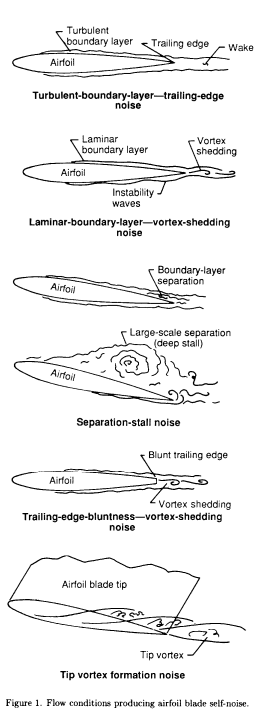

## References
[1] Thomas F. Brooks, D. Stuart Pope, and Michael A. Marcolini. Airfoil self-noise and prediction. NTRS Author
Affiliations: PRC Kentron, Inc., Hampton, NASA Langley Research Center NTRS Report/Patent Number: L-
16528 NTRS Document ID: 19890016302 NTRS Research Center: Legacy CDMS (CDMS). July 1989. url: https://ntrs.nasa.gov/citations/19890016302.

[2] Roberto Lopez. Airfoil Self-Noise Data Set. Mar. 2014. url: https://archive.ics.uci.edu/ml/datasets/airfoil+self-noise.

[3] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

## Import Modules

In [1]:
# libraries
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# PyTorch
import torch

# For PyTorch Dataset & Dataloader
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.transforms import ToTensor

# For PyTorch Neural Network
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

c:\Users\whdqk\anaconda3\envs\sam\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Check CUDA Availability

In [2]:
# check your PyTorch version
print(torch.__version__)

1.13.0


In [3]:
# check if GPU is available in your device
cuda_available = torch.cuda.is_available()
print(cuda_available)

True


In [4]:
# Set Device: check pytorch cuda and use cuda if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('*' * 50)
if torch.cuda.is_available():  
    print('CUDA is found: %s.' %torch.cuda.get_device_name(0))
else:
    print('CUDA not found! Training may be slow......')

**************************************************
CUDA is found: NVIDIA GeForce GTX 1650 with Max-Q Design.


## Airfoil Self-Noise Dataset

In [5]:
# dataset
dataset = np.loadtxt('airfoil_self_noise.dat')
dataset_df = pd.DataFrame(dataset)
dataset_df.columns = ["Frequency [Hz]", "Angle of attack [deg]", "Chord length [m]", "Free-stream velocity [m/s]", "Suction side displacement thickness [m]", "Scaled sound pressure level [dB]"]
dataset_df.head() # display first 5 rows

,Frequency [Hz],Angle of attack [deg],Chord length [m],Free-stream velocity [m/s],Suction side displacement thickness [m],Scaled sound pressure level [dB]
0,800.0,0.0,0.3048,71.3,0.002663,126.201
1,1000.0,0.0,0.3048,71.3,0.002663,125.201
2,1250.0,0.0,0.3048,71.3,0.002663,125.951
3,1600.0,0.0,0.3048,71.3,0.002663,127.591
4,2000.0,0.0,0.3048,71.3,0.002663,127.461


## Feature Engineering

### Normalize the Dataset

In [6]:
# normalize dataset
feature1_norm = (dataset[:,0]-dataset[:,0].mean())/dataset[:,0].std()
feature2_norm = (dataset[:,1]-dataset[:,1].mean())/dataset[:,1].std()
feature3_norm = (dataset[:,2]-dataset[:,2].mean())/dataset[:,2].std()
feature4_norm = (dataset[:,3]-dataset[:,3].mean())/dataset[:,3].std()
feature5_norm = (dataset[:,4]-dataset[:,4].mean())/dataset[:,4].std()
output_norm = (dataset[:,5]-dataset[:,5].mean())/dataset[:,5].std()
dataset_norm = np.hstack([
                        feature1_norm.reshape(-1,1), 
                        feature2_norm.reshape(-1,1), 
                        feature3_norm.reshape(-1,1), 
                        feature4_norm.reshape(-1,1), 
                        feature5_norm.reshape(-1,1), 
                        output_norm.reshape(-1,1)
                        ])

dataset_norm_df = pd.DataFrame(dataset_norm)
dataset_norm_df.columns = ["Frequency", "Angle of attack", "Chord length", "Free-stream velocity", "Suction side displacement thickness", "Scaled sound pressure level"]
dataset_norm_df

,Frequency,Angle of attack,Chord length,Free-stream velocity,Suction side displacement thickness,Scaled sound pressure level
0,-0.662023,-1.146403,1.799299,1.312935,-0.644805,0.197939
1,-0.598561,-1.146403,1.799299,1.312935,-0.644805,0.052935
2,-0.519235,-1.146403,1.799299,1.312935,-0.644805,0.161688
3,-0.408177,-1.146403,1.799299,1.312935,-0.644805,0.399494
4,-0.281255,-1.146403,1.799299,1.312935,-0.644805,0.380644
...,...,...,...,...,...,...
1498,-0.122601,1.490443,-0.373740,-0.723345,3.172773,-2.112990
1499,0.083648,1.490443,-0.373740,-0.723345,3.172773,-2.259444
1500,0.353359,1.490443,-0.373740,-0.723345,3.172773,-2.643705
1501,0.670666,1.490443,-0.373740,-0.723345,3.172773,-2.698806


### Shuffle the Dataset

In [7]:
dataset_norm_shuffled = copy.deepcopy(dataset_norm)
np.random.seed(0)
np.random.shuffle(dataset_norm_shuffled) # shuffle
dataset_norm_shuffled_df = pd.DataFrame(dataset_norm_shuffled)
dataset_norm_shuffled_df.columns = ["Frequency", "Angle of attack", "Chord length", "Free-stream velocity", "Suction side displacement thickness", "Scaled sound pressure level"]
dataset_norm_shuffled_df

,Frequency,Angle of attack,Chord length,Free-stream velocity,Suction side displacement thickness,Scaled sound pressure level
0,2.257200,-1.146403,-1.188629,1.312935,-0.816926,0.862927
1,1.083165,-1.146403,1.799299,1.312935,-0.644805,-0.767788
2,-0.122601,0.932649,-0.373740,-1.230809,2.338053,-2.105305
3,-0.788945,1.794694,-1.188629,1.312935,0.377619,-1.078821
4,-0.122601,1.456637,-0.916999,1.312935,1.162877,0.404424
...,...,...,...,...,...,...
1498,3.050467,-1.146403,-0.916999,-0.723345,-0.787172,-0.122955
1499,-0.519235,0.273437,-0.916999,-1.230809,-0.405612,0.771430
1500,-0.519235,2.606032,-1.188629,1.312935,0.781837,2.341968
1501,-0.519235,-0.233649,0.169520,0.298007,-0.517806,0.861477


### 80 10 10 Train Test Validation Split

In [8]:
dataset_norm_shuffled.shape # shape of dataset

(1503, 6)

In [9]:
# split the dataset into train, test, and validation
train_data = dataset_norm_shuffled[:1203]
test_data = dataset_norm_shuffled[1203:1353]
valid_data = dataset_norm_shuffled[1353:1503]

### Training Data

In [10]:
train_data_df = pd.DataFrame(train_data)
train_data_df

,0,1,2,3,4,5
0,2.257200,-1.146403,-1.188629,1.312935,-0.816926,0.862927
1,1.083165,-1.146403,1.799299,1.312935,-0.644805,-0.767788
2,-0.122601,0.932649,-0.373740,-1.230809,2.338053,-2.105305
3,-0.788945,1.794694,-1.188629,1.312935,0.377619,-1.078821
4,-0.122601,1.456637,-0.916999,1.312935,1.162877,0.404424
...,...,...,...,...,...,...
1198,0.353359,-1.146403,-0.916999,1.312935,-0.791078,1.391177
1199,-0.662023,0.983357,0.169520,-0.723345,3.595917,-1.200045
1200,-0.715965,0.273437,-0.916999,-1.230809,-0.405612,0.147912
1201,-0.788945,2.183460,-0.916999,-0.723345,1.927917,0.837841


### Test Data

In [11]:
test_data_df = pd.DataFrame(test_data)
test_data_df

,0,1,2,3,4,5
0,-0.122601,-0.335066,-1.188629,-0.723345,-0.778375,0.928034
1,0.670666,1.794694,-1.188629,-1.230809,0.496219,-0.991819
2,-0.598561,-1.146403,0.169520,1.312935,-0.725786,0.358313
3,-0.757215,-0.233649,0.169520,-1.230809,-0.447680,0.702553
4,-0.598561,-0.639317,1.799299,-1.230809,-0.444607,0.290306
...,...,...,...,...,...,...
145,-0.408177,-1.146403,-0.373740,-0.723345,-0.736092,1.221667
146,0.083648,0.087506,0.984410,-1.230809,0.161824,-1.683053
147,0.353359,0.070603,0.169520,1.312935,-0.275333,-0.796499
148,2.257200,-0.335066,-1.188629,-0.723345,-0.778375,0.178363


### Validation Data

In [12]:
valid_data_df = pd.DataFrame(valid_data)
valid_data_df

,0,1,2,3,4,5
0,2.257200,-1.146403,-0.373740,-1.230809,-0.733232,-1.296763
1,1.083165,-1.146403,-0.373740,1.312935,-0.755307,0.661082
2,1.622586,-0.892860,1.799299,-0.723345,-0.549132,-1.824867
3,-0.715965,-0.013911,-0.373740,-1.230809,-0.396369,1.055637
4,-0.519235,0.526980,0.169520,1.312935,0.620745,-0.312765
...,...,...,...,...,...,...
145,3.050467,-1.146403,-0.916999,-0.723345,-0.787172,-0.122955
146,-0.519235,0.273437,-0.916999,-1.230809,-0.405612,0.771430
147,-0.519235,2.606032,-1.188629,1.312935,0.781837,2.341968
148,-0.519235,-0.233649,0.169520,0.298007,-0.517806,0.861477


## Data Handling

### Custom Dataset

In [13]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.data = data
    
    def __len__(self):
        return len(self.data[:,0])
    
    def __getitem__(self, idx):
        features = self.data[:,0:-1][idx] # features values
        labels = self.data[:,-1][idx] # label (output): Sound Pressure Level
        return features, labels


## Neural Network Model Architecture

### Multi-Layer Perceptron

In [14]:
# Create a MLP
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_nodes=32, activation=nn.ReLU()): # __init__: let variables be global by having them as attributes of 'self'
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_nodes), # first hidden layer 1(input size, output size)
            activation,
            nn.Linear(hidden_nodes, hidden_nodes*4), # (input size, output size)
            activation,
            nn.Linear(hidden_nodes*4, hidden_nodes*16), # (input size, output size)
            activation,
            nn.Linear(hidden_nodes*16, hidden_nodes*4), # (input size, output size)
            activation,
            nn.Linear(hidden_nodes*4, hidden_nodes), # (input size, output size)
            activation,
            nn.Linear(hidden_nodes, output_size) # output layer (input size, output size)
            )

    def forward(self, input): # forward pass
        # input = input.to(torch.float32) # keep the input's dtype as float32
        input = input.float()
        return self.layers(input)

## Train

In [15]:
# Training
def train(model, train_dataset, valid_dataset, hyperparameters):

    # Hyperparameters
    epochs = hyperparameters["epochs"] # how many times you want to train
    lr = hyperparameters["lr"] # learning rate
    batch_size = hyperparameters["batch_size"] # how many data points you want to train at once
    weight_decay = hyperparameters["weight_decay"] # regularizer
    criterion = hyperparameters["criterion"] # loss function for regression task

    # Dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr) # optimizer = backprop + optimization; Optimze the parameters

    # initial variables
    train_loss_epoch = []; valid_loss_epoch = []

    # TRAINING
    for epoch in tqdm(range(epochs)):

        train_loss = 0; valid_loss =0 # reset at every epoch
        train_count = 0; valid_count = 0

        # TRAINING BY FITTING THE MODEL TO THE TRAINING DATA
        for batch, (features, labels) in enumerate(train_loader):
            features = features.to(device=device)
            labels = labels.unsqueeze(1).to(device=device) # unsqueeze(1) to add 1 more dimension
            # SET GRADIENTS TO 0 FOR EACH BATCH
            optimizer.zero_grad()
            # FORWARD PASS & PREDICTION
            pred = model(features)
            # COMPUTE LOSS
            loss = criterion(pred.float(), labels.float())
            # BACKPROPAGATION
            loss.backward()
            # UPDATE WEIGHTS
            optimizer.step()
            # LOSS SUM
            train_loss += loss.item()
            # COUNT ACTUAL BATCH SIZE
            train_count += 1

        # TRAINING BY FITTING THE MODEL TO THE VALIDATION DATA
        for batch, (features, labels) in enumerate(valid_loader):
            features = features.to(device=device)
            labels = labels.unsqueeze(1).to(device=device) # unsqueeze(1) to add 1 more dimension
            # FORWARD PASS & PREDICTION
            pred = model(features)
            # COMPUTE LOSS
            loss = criterion(pred.float(), labels.float())
            # LOSS SUM
            valid_loss += loss.item()
            # COUNT ACTUAL BATCH SIZE
            valid_count += 1
        
        # Loss over epochs
        train_loss_epoch.append(train_loss/train_count) # batch mean train loss per epoch
        valid_loss_epoch.append(valid_loss/valid_count) # batch mean validation loss per epoch
    
        # Print training progress
        if epoch % 100 == 0:
            print("Batch Mean Train Loss per Epoch: {0:.4f}\nBatch Mean Validation Loss per Epoch: {1:.4f}".format(train_loss/train_count, valid_loss/valid_count))

    # Save the trained model parameters
    torch.save(model.state_dict(), "./p1_model.pt")

    # Save the entire trained model
    torch.save(model, 'p1_whole_model.pt')
    
    return model, train_loss_epoch, valid_loss_epoch

## Train Loss, Validation Loss, Test Error

  0%|          | 2/500 [00:02<07:21,  1.13it/s]

Batch Mean Train Loss per Epoch: 0.8038
Batch Mean Validation Loss per Epoch: 0.3793


 20%|██        | 102/500 [00:20<01:16,  5.22it/s]

Batch Mean Train Loss per Epoch: 0.0241
Batch Mean Validation Loss per Epoch: 0.0680


 40%|████      | 202/500 [00:39<00:55,  5.35it/s]

Batch Mean Train Loss per Epoch: 0.0122
Batch Mean Validation Loss per Epoch: 0.0586


 60%|██████    | 301/500 [01:00<00:44,  4.45it/s]

Batch Mean Train Loss per Epoch: 0.0069
Batch Mean Validation Loss per Epoch: 0.0594


 80%|████████  | 401/500 [01:23<00:23,  4.29it/s]

Batch Mean Train Loss per Epoch: 0.0129
Batch Mean Validation Loss per Epoch: 0.0587


100%|██████████| 500/500 [01:47<00:00,  4.66it/s]


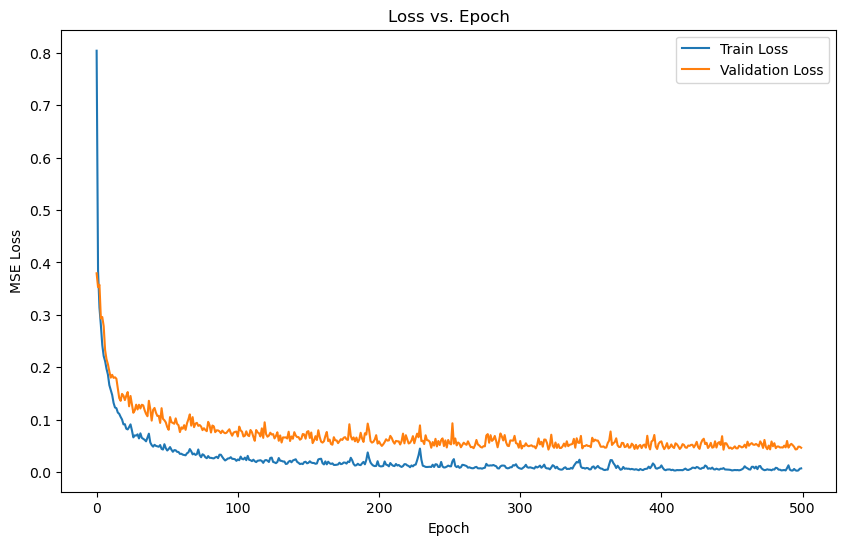

In [16]:
if __name__ == '__main__':
    torch.manual_seed(137)

    # Load in the provided data
    train_data
    valid_data
    test_data

    # Custom dataset
    train_dataset = CustomDataset(train_data)
    valid_dataset = CustomDataset(valid_data)

    # Hyperparameters
    hyperparameters = {
                    "epochs": 500, "batch_size": 2**5, "lr": 0.0005, 
                    "weight_decay": 1e-2, 
                    "criterion": nn.MSELoss(reduction='mean')
                    }
                    
    # input and output size
    num_features = 5 # the number of features
    input_size = num_features # input size = num of features
    num_output = 1 # the number of output
    output_size = num_output # output size = num of output


    # initialize network
    model = MLP(input_size=input_size, output_size=output_size).to(device)

    # trained model
    model_trained, train_losses, val_losses = train(model=model,
                                                    train_dataset=train_dataset, 
                                                    valid_dataset=valid_dataset,
                                                    hyperparameters=hyperparameters
                                                    )

    # Plot
    train_loss = train_losses
    valid_loss = val_losses
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(train_loss, label="Train Loss")
    ax.plot(valid_loss, label="Validation Loss")
    ax.legend(loc='best')
    ax.set_title("Loss vs. Epoch")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MSE Loss")
    plt.show()

### Compute Test Error

In [17]:
# custom dataset
test_dataset = CustomDataset(test_data)
# dataloader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [18]:
# compute test error for every data
with torch.no_grad(): # gradients won't be computed here
    error_list = []
    for batch, (features, labels) in enumerate(test_loader):
        features = features.to(device=device)
        labels = labels.unsqueeze(1).to(device=device) # unsqueeze(1) to add 1 more dimension
        prediction = model(features)
        error = nn.MSELoss()(prediction, labels).item()
        error_list.append(error)
    test_error = np.sum(error_list)


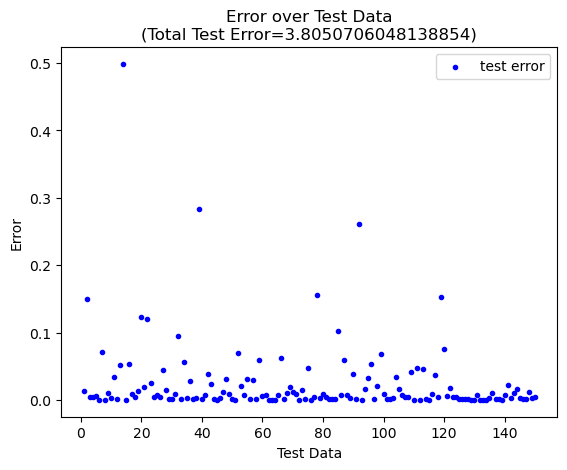

In [19]:
# plot test error
len_test = len(test_data[:,0])
plt.scatter(np.linspace(1,len_test,len_test), error_list, marker='.', c='b', 
    label=f'test error')
plt.title(f"Error over Test Data\n(Total Test Error={test_error})")
plt.xlabel("Test Data")
plt.ylabel("Error")
plt.legend()
plt.show()

## Evaluate Our Trained Model

In [20]:
def evaluate_model(model, test_data):
    test_dataset = CustomDataset(test_data)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    with torch.no_grad():
        total_loss = 0
        pred_list = []
        for features, label in test_loader:
            x = features.to(device=device) # features
            y = label.to(device=device) # ground truth label (scaled sound pressure level)
            pred = model(x) # prediction from the trained model
            pred_list.append(pred.item())
            total_loss += nn.MSELoss()(pred, y).item() # total test loss (error)
    print(f"Total Loss: {total_loss}")

    # normalized predictions
    pred_list_df = pd.DataFrame(pred_list)
    pred_list_df.columns = ["Predicted normalized scaled sound pressure level"]
    predicted_sound_pressureds = pred_list_df

    # normalized ground truths
    test_data_df = pd.DataFrame(test_data)
    ground_truth_sound_pressures = test_data_df.iloc[:,-1:]
    ground_truth_sound_pressures.columns = ["Ground truth normalized scaled sound pressure level"]

    # compare
    compare_df = pd.concat([ground_truth_sound_pressures, predicted_sound_pressureds], axis=1)

    return compare_df


In [21]:
evaluate_model(model_trained, test_data)

Total Loss: 3.8050706048138836


c:\Users\whdqk\anaconda3\envs\sam\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


,Ground truth normalized scaled sound pressure level,Predicted normalized scaled sound pressure level
0,0.928034,1.041295
1,-0.991819,-0.604125
2,0.358313,0.294616
3,0.702553,0.766582
4,0.290306,0.368917
...,...,...
145,1.221667,1.194824
146,-1.683053,-1.652707
147,-0.796499,-0.690206
148,0.178363,0.121259
